# Productivity Tracking with Python and the Notion API

With the recent release of the very much anticipated beta version of the [Notion API](https://developers.notion.com) a lot of integrations are now possible, and in terms of data science projects an entire universe of possibilities is now open.

<span style="color: red"> reconsider phrasing </span> 

___In this post I will show you how to build a simple python API to interact with the Notion API to fetch and visualize data to track your progress in different personal projects___

## Setting up the Notion API

To start things off, you need to first create an integration token on your notion page and then share your database with that integration. A detailed instrutional on how to do that can be found [here](https://developers.notion.com/docs/getting-started)

## Setting up a simple python api to fetch data from your database

Now you will set up a simple python API to communicate with your database in the notion app so you can fetch the data needed to run whatever analysis you want to do.
In this case I created a simple database with each property (column on the table) being a project plus the date column and each row containing a checkbox representing whether or not that project was worked on that given day.

On my Notion page is looks like this:

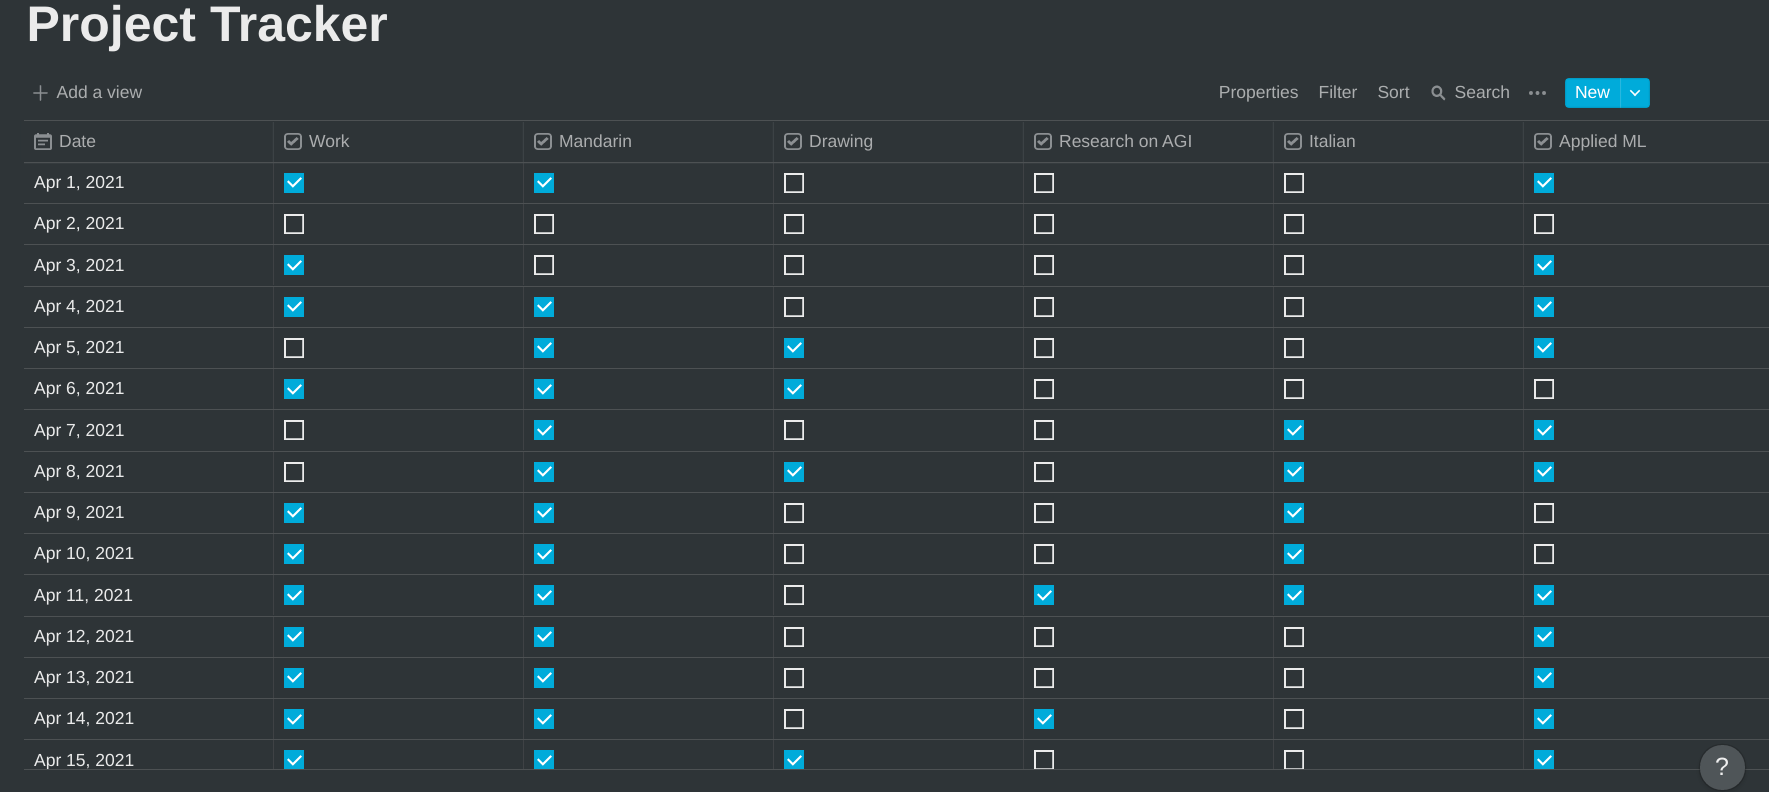

I already ran through the Notion API set up that I mentioned before, so I have this database ready to go.

We will write a class with 3 methods:
1. `query_databases()` to fetch the data from the notion app
2. `get_projects_titles` to get the names of the projects you are tracking (they will be the titles of the columns in your notion database)
3. `get_projects_data` to get the projects tracking data from the resulting json file.

<span style="color: red"> review this part </span> 

The full code for the python API part looks like this:

In [172]:
DATABASE_ID = "YOUR DATABASE ID"
NOTION_URL = 'https://api.notion.com/v1/databases/'

class NotionSync:
    def __init__(self):
        pass    

    def query_databases(self,integration_token="YOUR INTEGRATION TOKEN"):
        database_url = NOTION_URL + DATABASE_ID + "/query"
        response = requests.post(database_url, headers={"Authorization": f"{integration_token}"})
        if response.status_code != 200:
            raise ApiError(f'Response Status: {response.status_code}')
        else:
            return response.json()
    
    def get_projects_titles(self,data_json):
        return list(data_json["results"][0]["properties"].keys())
    

    def get_projects_data(self,data_json,projects):
        projects_data = {}
        for p in projects:
            if p!="Name" and p !="Date":
                projects_data[p] = [data_json["results"][i]["properties"][p]["checkbox"]
                                    for i in range(len(data_json["results"]))]
            elif p=="Date":
                dates = [data_json["results"][i]["properties"]["Date"]["date"]["start"]
                                    for i in range(len(data_json["results"]))]

        
        return projects_data,dates

nsync = NotionSync()
data = nsync.query_databases()
projects = nsync.get_projects_titles(data)
projects_data,dates = nsync.get_projects_data(data,projects)

Let's do a quick breakdown of each component:

1. Querying the database

In [166]:
def query_databases(self,integration_token="YOUR INTEGRATION TOKEN"):
    database_url = NOTION_URL + DATABASE_ID + "/query"
    response = requests.post(database_url, headers={"Authorization": f"{integration_token}"})
    if response.status_code != 200:
        raise ApiError(f'Response Status: {response.status_code}')
    else:
        return response.json()

Here we are sending a post request to our database using the integration token from the Notion API, we return the response as a json object to facilitate getting the data in the shape we need to visualize it later.

2. Getting the names of the projects

In [ ]:
def get_projects_titles(self,data_json):
    return list(data_json["results"][0]["properties"].keys())

Here we are simply getting all the properties in our database following the instructions to work with databases from the Notion API page that you can find [here](https://developers.notion.com/docs/working-with-databases).


3. Getting the projects data

In [ ]:
def get_projects_data(self,data_json,projects):
    projects_data = {}
    for p in projects:
        if p!="Name" and p !="Date":
            projects_data[p] = [data_json["results"][i]["properties"][p]["checkbox"]
                                for i in range(len(data_json["results"]))]
        elif p=="Date":
            dates = [data_json["results"][i]["properties"]["Date"]["date"]["start"]
                                for i in range(len(data_json["results"]))]


    return projects_data,dates

Finally here we are fetching the data from each project as well as the column with the dates so we can plot an events timeline of our progress with each project.

## Setting up visualizations with streamlit and plotly

Now that we have the data loaded up, let's use the `plotly` package to plot the information we want. Here I want to do something simple and plot a pie chart with the amount of time spent on each project over the tracked period (last 45 days)and an event plot that shows my daily activity tracker (whether or not I worked on project X). 

Let's start by importing our dependencies

In [171]:
import plotly.graph_objs as go
import pandas as pd
from notion_api import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now we use our python API to fetch the data from our Notion database.

In [102]:
nsync = NotionSync()
data = nsync.query_databases()
projects = nsync.get_projects_titles(data)
projects_data,dates = nsync.get_projects_data(data,projects)

Now we set up a dataframe with the data we want and plot the events tracker and the pie chart.

In [173]:
def setupProjectsDf(projects_data,dates):
    df = pd.DataFrame(projects_data)
    df["date"] = dates
    
    return df


def projects_pie_chart(df):
    projectsTracker = [df[p].sum() for p in df.columns if p!="date"]
    labels = [p for p in df.columns if p!="date"]
        
    fig = go.Figure(data=[go.Pie(labels=labels, values=projectsTracker)])
    fig.update_layout(title="Projects Tracker")

    return fig

df = setupProjectsDf(projects_data, dates)
fig = projects_pie_chart(df)
fig.show()

It works perfect! The really cool thing about this is that as we update our notion page this plot will update automatically without any extra effort needed.

Now let's plot an events plot that tells us what we are working on each day over a given time period.
The first things we will need is to turn the True and False statements from the checkboxes into values that we can plot in such a way that each line in the y-axis represents a different project and each dot over that line region will represent having worked on that project on that given day. 

In [174]:
def projects_scatter_plot(df):
    colormap = {}
    colorsChart = []
    colors = list(range(len(projects_data.keys())))
    for i,w in enumerate(set(projects_data.keys())):
        colormap[w] = colors[i]
    
    colorsChart = [colormap[p] for p in df.columns if p!="date"]
    
    projects = [p for p in df.columns if p!="date"]
    
    fig = go.Figure(data=[go.Scatter(x=df["date"], y=df[p],mode="markers",name=p) for p in df.columns if p!="date"])
    fig.update_layout(yaxis=dict(tickvals=[df[df[p]>0][p].iloc[0] for p in df.columns if p!="date"], ticktext = [p for p in df.columns if p!="date"]),
                     title="Project Events Tracker")
    fig.update_yaxes(rangemode="nonnegative")
    
    return fig

i=1
for p in df.columns:
    if p!="date" and p!="Name":
        df[p] = df[p].apply(lambda x: i if x==True else -0.5)
        i+=1


fig.show()

There we have it. To finish things off let's wrap this code on a streamlit app so that we can look at our data anytime we want by just running a command on the terminal.

To do that we just need a few lines of code that just wrap what we wrote so far on a simple streamlit script: 

In [ ]:
@st.cache
def load_data():
    nsync = NotionSync()
    data = nsync.query_databases()
    projects = nsync.get_projects_titles(data)
    projects_data,dates = nsync.get_projects_data(data,projects)
    df = setupProjectsDf(projects_data,dates)
    return df

    

df = load_data()
i=1
for p in df.columns:
    if p!="date" and p!="Name":
        df[p] = df[p].apply(lambda x: i if x==True else -0.5)
        i+=1


st.title("Project Tracker")
# Set up: load and set up the data and write loading message
data_load_state = st.text('Loading data...')
data_load_state.text('Loading data...done!')
# Plotting Projects Stats
st.subheader("Project Tracker")
project_time_spents = projects_pie_chart(df)
st.write(project_time_spents)
project_events = projects_scatter_plot(df)
st.write(project_events)

The `load_data` functions takes care of the data part fetching it directly from our Notion database and the following is just setting up a title and a subheader for the plots. The minimalistic style of streamlit makes this really simple.

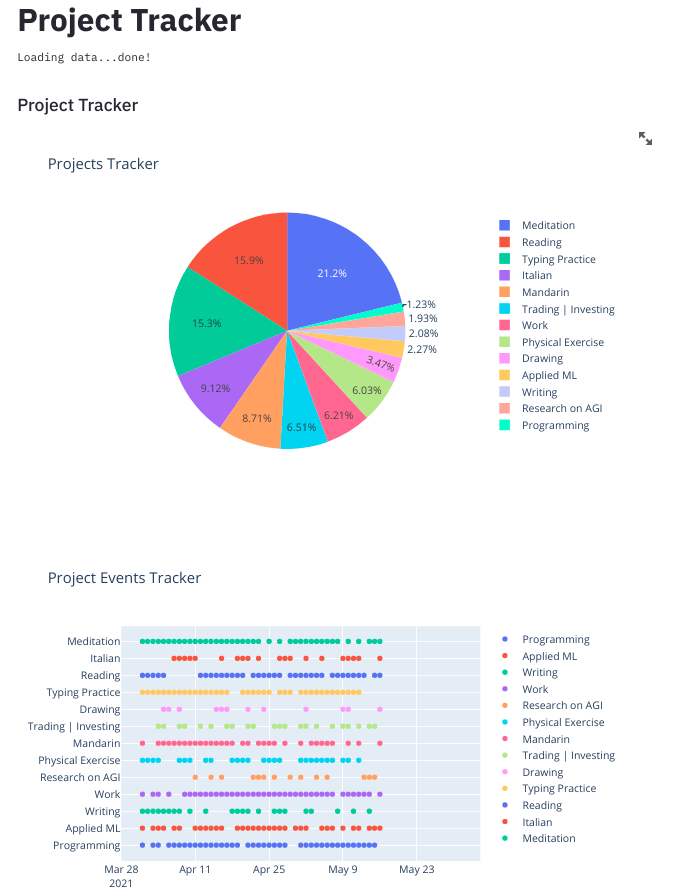

# Final Thoughts on Using the Notion API with Data Science Projects

This new beta version of the Notion API is really cool. But when I went to the website I saw that they only had an SDK in javascript which led me to write a little bit of code to make it work nicely with python. I should say as a disclaimer that I am not an expert on writing API's and I may have written a few things sub-optimallly here, but for the purpose that I set out to just quickly fetch data from my Notion databases this actually turned out quite nice.

The integrations that Notion now offers with this official API can really take productivity projects with this data science approach to a whole other level and I feel like we will see more and more really interesting features appearing in the upcoming future.

<span style="color: red"> rewrite </span> 

If you liked this post connect with me on [Twitter](https://twitter.com/LucasEnkrateia), [LinkedIn](https://www.linkedin.com/in/lucas-soares-969044167/) and follow me on [Medium](https://lucas-soares.medium.com). 
Thanks and see you next time! :)


# References
- [Getting Started with the Notion API](https://developers.notion.com/docs/getting-started)
- [working with databases in Notion](https://developers.notion.com/docs/working-with-databases)
- [retrieve database in Notion](https://developers.notion.com/reference/get-database)
- [Python API integration tutorial](https://realpython.com/api-integration-in-python/)
- [Streamlit](https://streamlit.io)